# 영상 속의 물체 추적하기
- 표적의 위치는 영상 처리 알고리즘(Object Detection 등)으로 알아내야 함
- 칼만필터는 획득한 추정값에 오차를 제거하고, 이동속도를 추정하는 역할

## 시스템 모델

### 상태변수 정의
- 평면 상의 표적 추적에 칼만필터를 적용하기 위해 앞 장의 위치-속도 모델을 2차원으로 확장
- 상태변수를 가로방향(x축)의 위치와 속도, 세로방향(y축)의 위치와 속도로 설정하고 시스템 모델 유도
- 상태변수의 위치는 중요하지 않음 : (위치x, 위치y, 속도x, 속도y) 이렇게 설정해도 상관없음

### 상태변수 정의에 따른 시스템 모델
- xk+1 = Axk + wk
- zk = Hxk + vk


- 시스템 모델은 위치와 속도 사이의 관계를 2차원 평면으로 확장한 것
- 대상 표적의 위치는 영상처리 알고리즘으로 찾아 칼만필터에 입력, 속도는 측정하지 않음

## 칼만필터함수
- 공 이미지를 추적하는 예제

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy.linalg import inv
from skimage.metrics import structural_similarity

np.random.seed(0)

In [2]:
def kalman_filter(z_meas, x_esti, P):
    """칼만필터 알고리즘 (매개변수 : 측정값, 추정값, 오차공분산)"""
    # (1) Prediction.
    x_pred = A @ x_esti
    P_pred = A @ P @ A.T + Q

    # (2) Kalman Gain.
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    x_esti = x_pred + K @ (z_meas - H @ x_pred)

    # (4) Error Covariance.
    P = P_pred - K @ H @ P_pred

    return x_esti, P

- get_ball_pos 함수 : 공의 위치를 찾아내는 알고리즘

In [16]:
def get_ball_pos(iimg=0):
    """Return measured position of ball by comparing with background image file.
        - References:
        (1) Data Science School:
            https://datascienceschool.net/view-notebook/f9f8983941254a34bf0fee42c66c5539
        (2) Image Diff Calculation:
            https://www.pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python
    """    
    # Read images.
    imageA = cv2.imread('./data/10.TrackKalman/Img/bg.jpg')
    imageB = cv2.imread('./data/10.TrackKalman/Img/{}.jpg'.format(iimg+1))

    # Convert the images to grayscale.
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

    # 두 이미지 사이의 구조적 유사성 지수(SSIM) 계산, 차이 이미지가 반환되는지 확인.
    _, diff = structural_similarity(grayA, grayB, full=True)
    diff = (diff * 255).astype('uint8') 

    # 서로 다른 두 이미지(배경, 공)의 영역을 구하기 위해 이미지 임계값 지정 후 윤곽선 찾기 
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    M = cv2.moments(contours[0])
    xc = int(M['m10'] / M['m00'])  # center of x as true position.
    yc = int(M['m01'] / M['m00'])  # center of y as true position.

    v = np.random.normal(0, 15)  # v: 위치의 측정잡음

    xpos_meas = xc + v  # x_pos_meas: 위치x의 측정값 (observable). 
    ypos_meas = yc + v  # y_pos_meas: 위치y의 측정값 (observable). 

    return np.array([xpos_meas, ypos_meas])


In [5]:
# Input parameters.
n_samples = 24
dt = 1

In [6]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
A = np.array([[ 1, dt,  0,  0],
              [ 0,  1,  0,  0],
              [ 0,  0,  1, dt],
              [ 0,  0,  0,  1]])
H = np.array([[ 1,  0,  0,  0],
              [ 0,  0,  1,  0]])
Q = 1.0 * np.eye(4)
R = np.array([[50,  0],
              [ 0, 50]])

# Initialization for estimation.
x_0 = np.array([0, 0, 0, 0])  # (x-pos, x-vel, y-pos, y-vel) by definition in book. / 추정값 초기위치
P_0 = 100 * np.eye(4)

In [7]:
xpos_meas_save = np.zeros(n_samples)
ypos_meas_save = np.zeros(n_samples)
xpos_esti_save = np.zeros(n_samples)
ypos_esti_save = np.zeros(n_samples)

In [10]:
x_esti, P = None, None
for i in range(n_samples):
    z_meas = get_ball_pos(i)
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)

    xpos_meas_save[i] = z_meas[0]
    ypos_meas_save[i] = z_meas[1]
    xpos_esti_save[i] = x_esti[0]
    ypos_esti_save[i] = x_esti[2]

### 추적 결과

(250.0, -10.0)

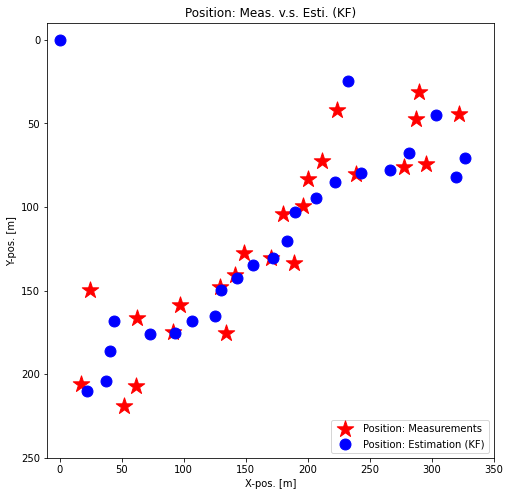

In [17]:
fig = plt.figure(figsize=(8, 8))
plt.gca().invert_yaxis()
plt.scatter(xpos_meas_save, ypos_meas_save, s=300, c="r", marker='*', label='Position: Measurements')
plt.scatter(xpos_esti_save, ypos_esti_save, s=120, c="b", marker='o', label='Position: Estimation (KF)')
plt.legend(loc='lower right')
plt.title('Position: Meas. v.s. Esti. (KF)')
plt.xlabel('X-pos. [m]')
plt.ylabel('Y-pos. [m]')
plt.xlim((-10, 350))
plt.ylim((250, -10))

- 칼만필터의 추정위치가 측정값보다 대각선에 더 가깝게 위치함 (공은 실제로 대각선 움직임)
- 추정값의 초기위치가 (0,0)으로 설정되어 있어 초기 오차 큰 모습보임

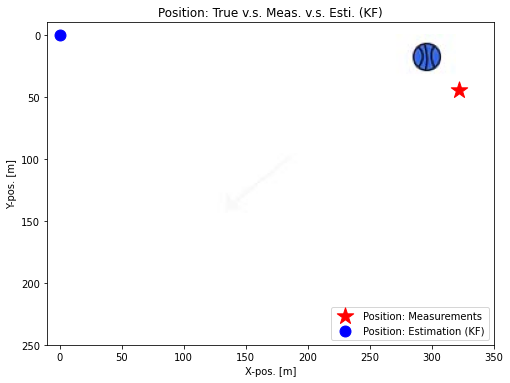

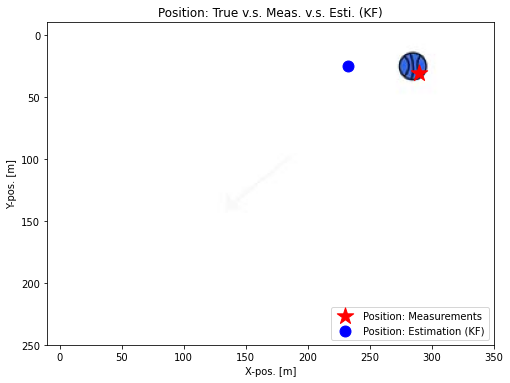

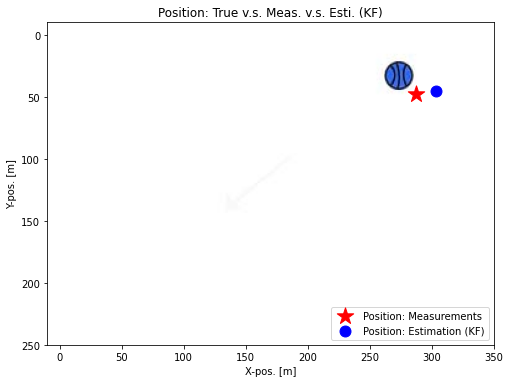

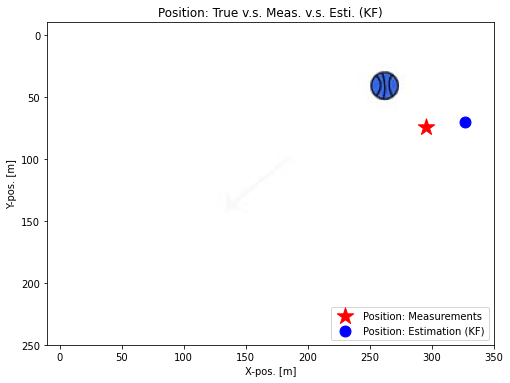

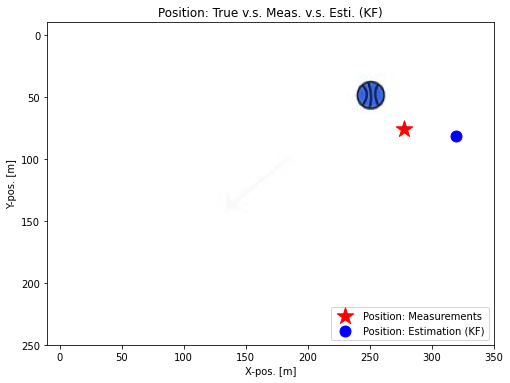

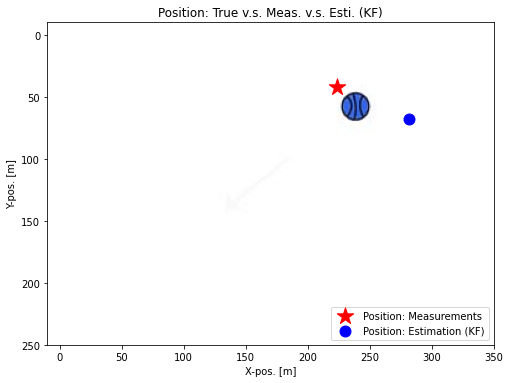

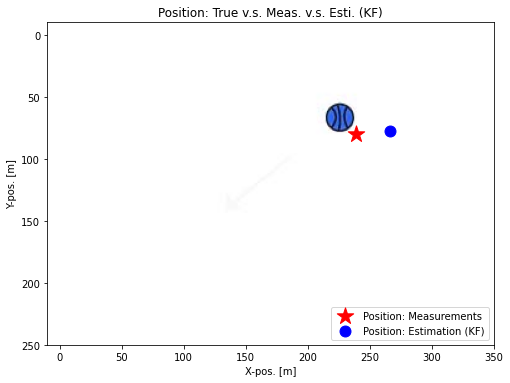

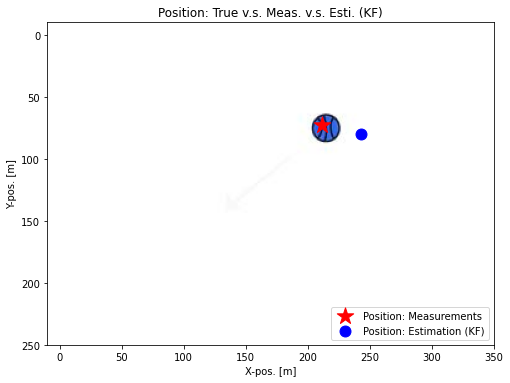

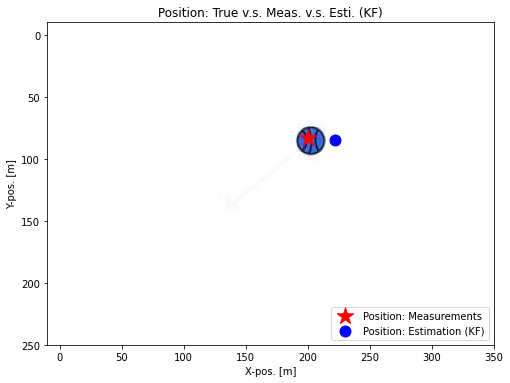

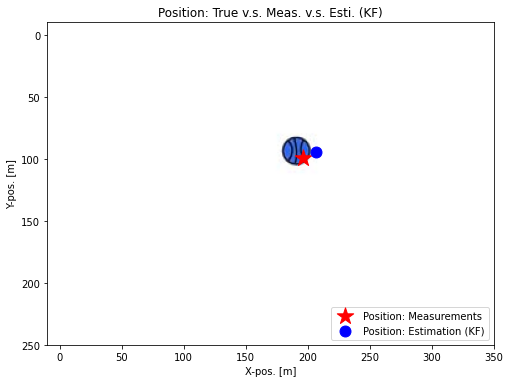

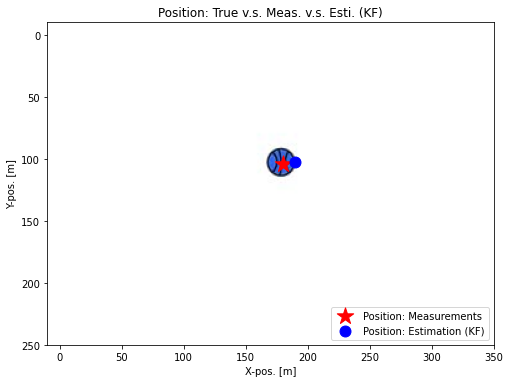

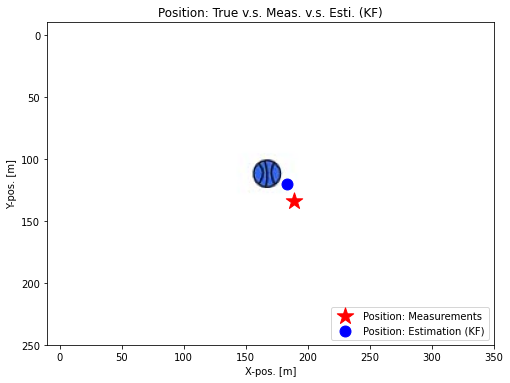

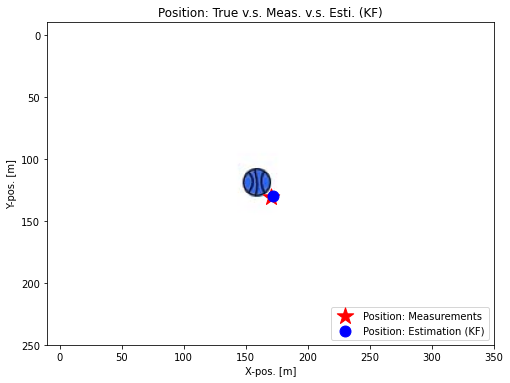

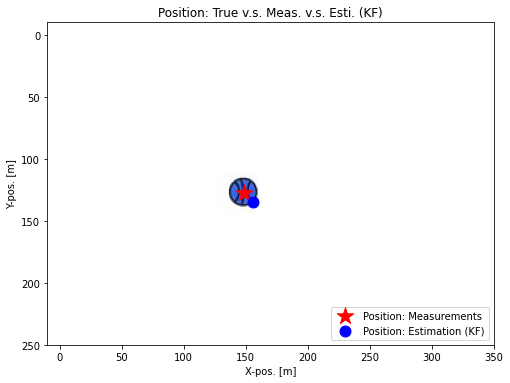

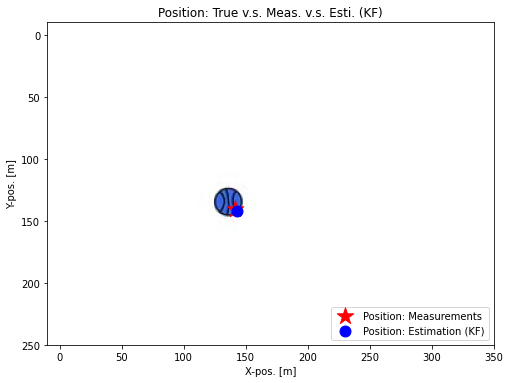

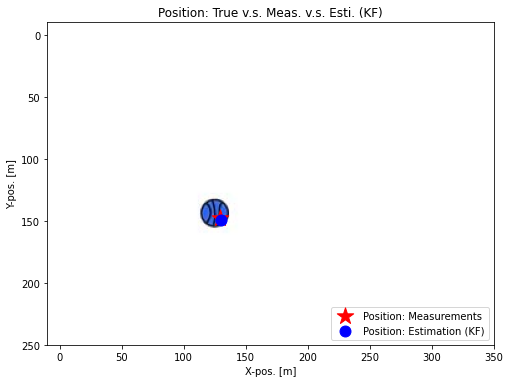

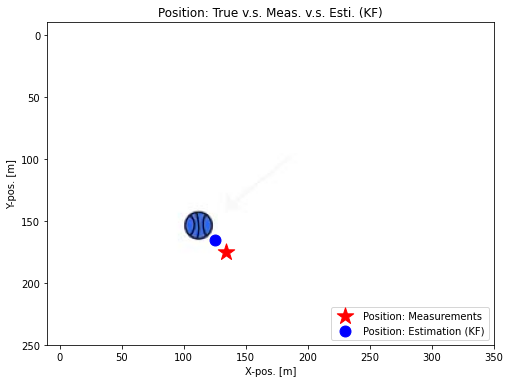

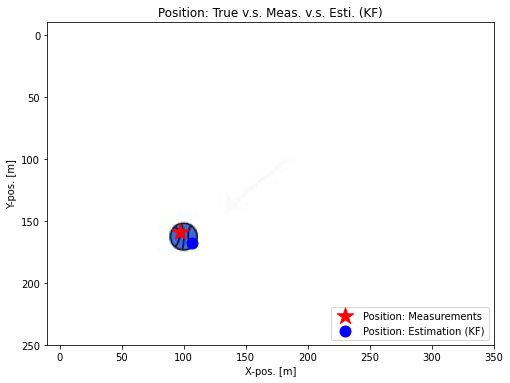

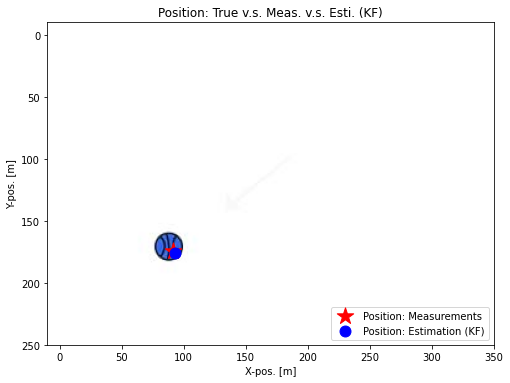

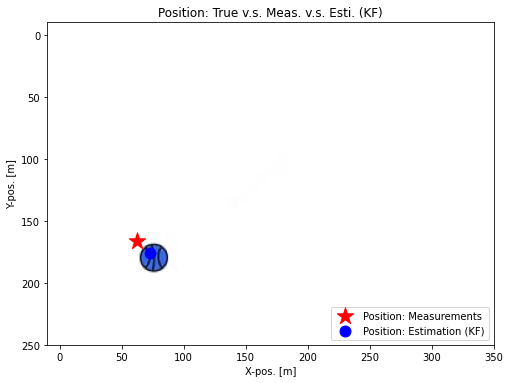

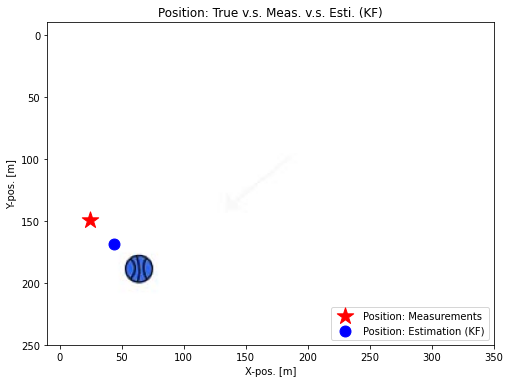

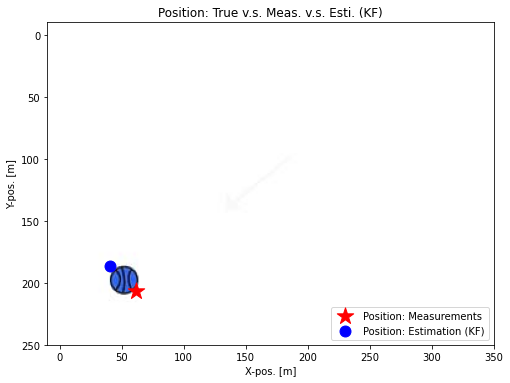

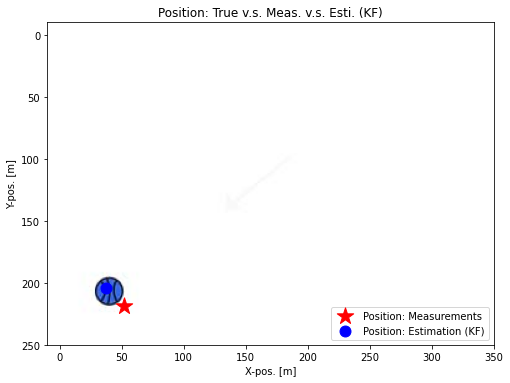

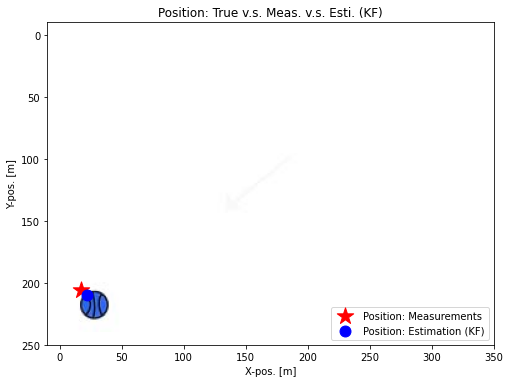

In [15]:
plt.ion()    
for i in range(n_samples):
    fig = plt.figure(figsize=(8, 8))    
    image = cv2.imread('./data/10.TrackKalman/Img/{}.jpg'.format(i+1))
    imgplot = plt.imshow(image)
    plt.scatter(xpos_meas_save[i], ypos_meas_save[i], s=300, c="r", marker='*', label='Position: Measurements')
    plt.scatter(xpos_esti_save[i], ypos_esti_save[i], s=120, c="b", marker='o', label='Position: Estimation (KF)')
    plt.legend(loc='lower right')
    plt.title('Position: True v.s. Meas. v.s. Esti. (KF)')
    plt.xlabel('X-pos. [m]')
    plt.ylabel('Y-pos. [m]')
    plt.xlim((-10, 350))
    plt.ylim((250, -10))
    fig.canvas.draw()
    plt.show()
    plt.pause(0.05)

## 행렬 Q와 R 조율하여 성능 개선하기
- 행렬 Q의 크기가 커지면, 칼만이득이 커져 추정결과가 측정값에 더 가까워짐
- 행렬 Q의 크기가 작아지면, 칼만이득이 작아져 추정결과가 이전추정값과 비슷해짐 (더 매끄러운 궤적)
- 행렬 R은 행렬Q와 반대의 영향을 줌